In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('../input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv')
df.head()

## Целевой признак — churn, который говорит о том, покинет ли клиент телефонную компанию. Рассматривается задача классификации.

In [ ]:
df.churn.value_counts()

In [ ]:
sns.countplot(df['churn'])

### Классы несбалансированы. Лояльных клиентов гораздо больше, чем тех, кто меняет оператора. Поэтому для оценки качества модели буду использовать f1_score с параметром average='binary' (это значение аттрибута average принято по-умолчанию).

In [ ]:
states = df.state.unique()
states_num = {}
for i in range(len(states)):
    states_num[states[i]] = i
df['states_num'] = df['state'].map(states_num)

In [ ]:
df.drop('state', axis=1, inplace=True)

df['churn_'] = df['churn'].map({True: 1, False: 0})
df.drop('churn', axis=1, inplace=True)

df['international_plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df.drop('international plan', axis=1, inplace=True)

df['voice_mail_plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})
df.drop('voice mail plan', axis=1, inplace=True)

df.drop('phone number', axis=1, inplace=True)

In [ ]:
y = df['churn_']
X = df.drop(labels = ['churn_'],axis = 1) 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.3, 
                                                      random_state=19)

# Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=2019, max_depth=3)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_valid)
f1_score(y_valid, y_pred)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', feature_names=X.columns.values)
print(open('tree.dot').read()) 

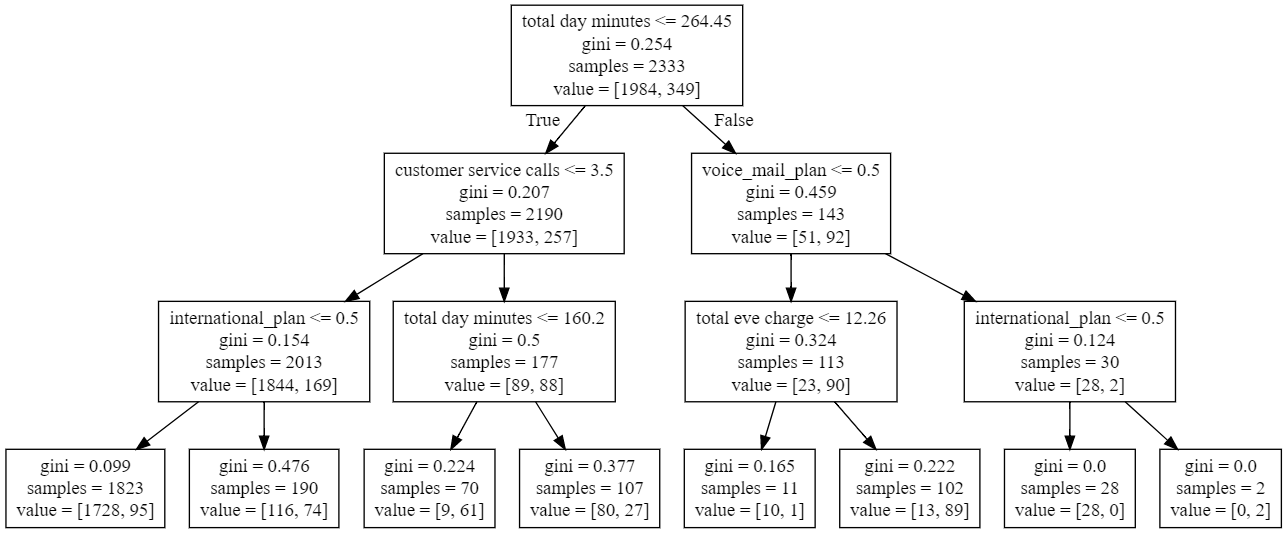

# Настройка гиперпараметров дерева

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)

tree_params = {'max_depth': np.arange(5, 10),
               'min_samples_leaf': np.arange(5, 10),
               'min_samples_split': np.arange(5, 10),
               'max_features': np.arange(10, 15)}
tree_grid = GridSearchCV(tree, tree_params, cv=kf, scoring=f1)

tree_grid.fit(X_train, y_train)

In [ ]:
tree_grid.best_estimator_

In [ ]:
tree_grid.best_score_

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16,10))

ax[0].plot(tree_grid.cv_results_['param_max_depth'].data, tree_grid.cv_results_['mean_test_score']) # accuracy vs max_depth
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Mean f1_score on test set')

ax[1].plot(tree_grid.cv_results_['param_min_samples_leaf'].data, tree_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[1].set_xlabel('min_samples_leaf')

ax[2].plot(tree_grid.cv_results_['param_min_samples_split'].data, tree_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[2].set_xlabel('min_samples_split')

ax[3].plot(tree_grid.cv_results_['param_max_features'].data, tree_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[3].set_xlabel('max_features')

## В моём случае параметр min_samples_split почти не влияет на качество модели.

In [ ]:
best_tree = tree_grid.best_estimator_
y_pred = best_tree.predict(X_valid)
f1_score(y_valid, y_pred)

In [ ]:
# from sklearn.tree import export_graphviz
# export_graphviz(best_tree, out_file='best_tree.dot', feature_names=X.columns.values)
# print(open('best_tree.dot').read()) 

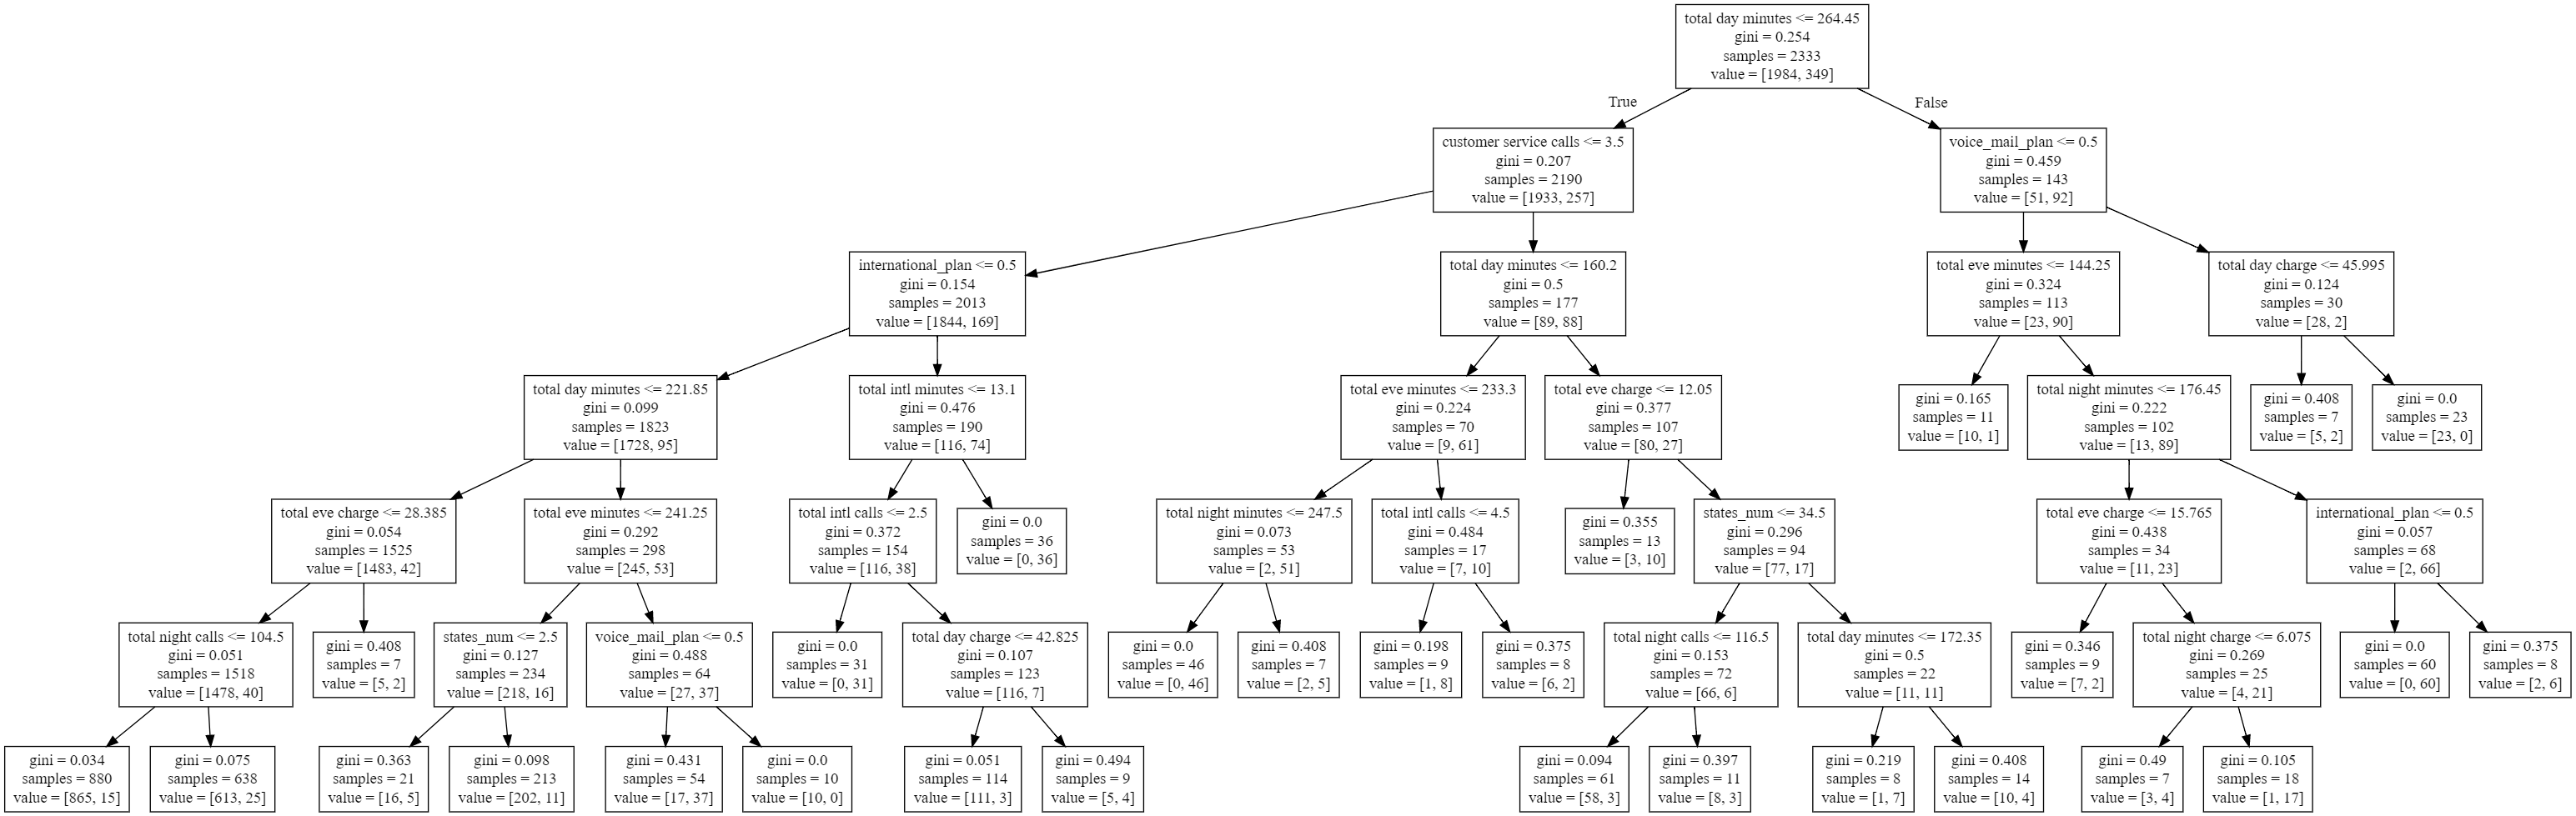

In [ ]:
features = {'f'+str(i+1):name for (i, name) in zip(range(len(X)), X)}

importances = best_tree.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

## Вывод: Настройка гипрепараметров улучшила модель.
В итоге модель предсказывает с f1-мерой = 0.79 (до настройки гаперпараметров 0.67).
Важнейшим признаком является total_day_minutes(проедположительно среднее кол-во минут, потраченых за день).

# Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2019)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)

f1_score(y_valid, y_pred)

In [ ]:
features = {'f'+str(i+1):name for (i, name) in zip(range(len(X)), X)}

indices = np.argsort(importances)[::-1]
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

importances = rf.feature_importances_

print("Feature ranking:")
for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])
    
plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

In [ ]:
forest_params = {'n_estimators': [50, 100, 200],
                 'max_depth': np.arange(10, 14),
                 'min_samples_leaf': np.arange(3, 6),
                 'min_samples_split': np.arange(3, 6),
                 'max_features': np.arange(10, 14)}
rf_grid = GridSearchCV(rf, forest_params, scoring=f1, cv=kf)
rf_grid.fit(X_train, y_train)

In [ ]:
rf_grid.best_estimator_

In [ ]:
rf_grid.best_score_

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20,10))

ax[0].plot(rf_grid.cv_results_['param_n_estimators'].data, rf_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('Mean precision on test set')

ax[1].plot(rf_grid.cv_results_['param_max_depth'].data, rf_grid.cv_results_['mean_test_score']) # accuracy vs max_depth
ax[1].set_xlabel('n_estimators')

ax[2].plot(rf_grid.cv_results_['param_min_samples_leaf'].data, rf_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[2].set_xlabel('min_samples_leaf')

ax[3].plot(rf_grid.cv_results_['param_min_samples_split'].data, rf_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[3].set_xlabel('min_samples_split')

ax[4].plot(rf_grid.cv_results_['param_max_features'].data, rf_grid.cv_results_['mean_test_score']) # accuracy vs min_samples_leaf
ax[4].set_xlabel('max_features')

In [ ]:
best_forest = rf_grid.best_estimator_
y_pred = best_forest.predict(X_valid)
f1_score(y_valid, y_pred)

In [ ]:
importances = best_forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices]);

## Вывод: Случайный лес предсказывает лучше, чем дерево решений.
Но мой подбор гиперпараметров не улучшил, а ухудшил качество.
Рассмотрю случайный лес с лучшим показателем качества: важнейшим признаком является total_day_charge(проедположительно среднее кол-во денег, потраченых за день). Важнейший в случае дерева признак total_day_minutes имеет почти такое же влияние на результат как total_day_charge.

# Метод ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
f1_score(y_valid, y_pred)

## В этой задаче RandomForest лидирует по качетсву предсказаний, дерево решений также показывает неплохой результат, а вот метод knn сильно отстает.